# LightGBM Stock/ETF Forecasting
## (Supplementary Notebook)
Compiled by Leo R. De Velez

This supplementary notebook applies the methodology used in the M5 Forecasting notebook, the LightGBM, on stock and etf price time series. In this supplementary notebook, we will be forecasting the Google (GOOG) stock price for the next 23 trading days starting November 14, 2022.
<br><br>
An earlier version of this Supplementary Notebook was used by Leo R. De Velez to participant in the 10th Month of the M6 Competition.  This latest version will be used to submit revised Stock/ETF positions for the 11th Month of the M6 Competition.
<br><br>
Most of the codes on this supplementary notebook  were copied from the previous notebook of this chapter, the "Winningest Methods in Time Series Forecasting", that was compiled by Sebastian C. Ibañez. 
<br><br>
Some of the codes from the previous notebook were removed, replaced, or modified and some new codes were added as needed by Leo R. De Velez.

## 1. Import the Python Modules

Import the necessary python modules.

In [1]:
## Copied from previous notebook and modified as needed

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import MultiOutputRegressor

import yfinance as yf

## 2. Load the Stock/ETF Dataset

Read and load the Stock/ETF Dataset.

Below are the Stocks/ETFs Ticker Names that are included in the M6 Competition:

ABBV,ACN,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,BDX,BF-B,BMY,BR,CARR,CDW,CE,CHTR,CNC,CNP,COP,
CTAS,CZR,DG,DPZ,DRE,DXC,META,FTV,GOOG,GPC,HIG,HST,JPM,KR,OGN,PG,PPL,PRU,PYPL,RE,ROL,ROST,UNH,
URI,V,VRSK,WRK,XOM,
IVV,IWM,EWU,EWG,EWL,EWQ,IEUS,EWJ,EWT,MCHI,INDA,EWY,EWA,EWH,EWZ,EWC,IEMG,LQD,HYG,SHY,IEF,TLT,
SEGA.L,IEAA.L,HIGH.L,JPEA.L,IAU,SLV,GSG,REET,ICLN,IXN,IGF,IUVL.L,IUMO.L,SPMV.L,IEVL.L,IEFM.L,
MVEU.L,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLU,XLP,XLB,VXX

In this Supplementary Notebook, we will look at the Google Stock (GOOG).

In [2]:
ticker = 'GOOG'
filename = ticker+'.csv'
startdate = '2012-01-31'
enddate = '2022-11-13'
df = yf.download(ticker, start=startdate, end=enddate)
df.to_csv(filename)

[*********************100%***********************]  1 of 1 completed


In [3]:
df = pd.read_csv(filename, index_col='Date')
df = df.dropna()

## 3. Examine the Dataset

Print and plot the dataset.

<bound method NDFrame.head of                 Close
Date                 
2012-01-31  14.448593
2012-02-01  14.466526
2012-02-02  14.573126
2012-02-03  14.852579
2012-02-06  15.170388
...               ...
2022-11-07  88.650002
2022-11-08  88.910004
2022-11-09  87.400002
2022-11-10  94.169998
2022-11-11  96.730003

[2716 rows x 1 columns]>
Index(['2012-01-31', '2012-02-01', '2012-02-02', '2012-02-03', '2012-02-06',
       '2012-02-07', '2012-02-08', '2012-02-09', '2012-02-10', '2012-02-13',
       ...
       '2022-10-31', '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04',
       '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10', '2022-11-11'],
      dtype='object', name='Date', length=2716)


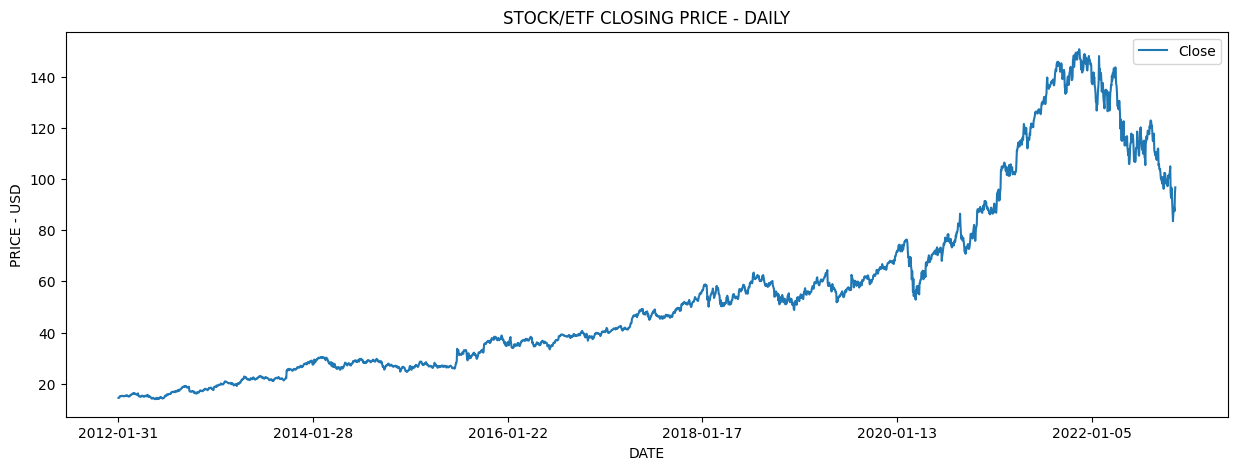

In [4]:
## Copied from previous notebook and modified as needed

series = pd.DataFrame(df['Close'])
print(series.head)
print(series.index)

plot_x_size = 15
plot_y_size = 5 
plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]
np.set_printoptions(precision = 6, suppress = True)
series.plot()
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DATE")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 4. Define the Data Preparation

Define the procedure for slicing the datasets into arrays of Independent and Dependent Variables.

In [5]:
## Copied from previous notebook and modified as needed

### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

## 5. Prepare the Training and Testing Datasets

Split the x and y arrays into training and testing datasets.

However, due to the high volatility in the past 20% of the stock historical prices, the 80-20 data split rule of thumb will not be used.  Instead, a much shorter testing datase will be used to allow the model to see more of the volatilty periods.

In [6]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 45
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
#test_size = int(len(series)*0.2)
test_size = 23
split_time = len(series) - test_size
train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2648, 45)
(2648,)
(23, 45)
(23,)


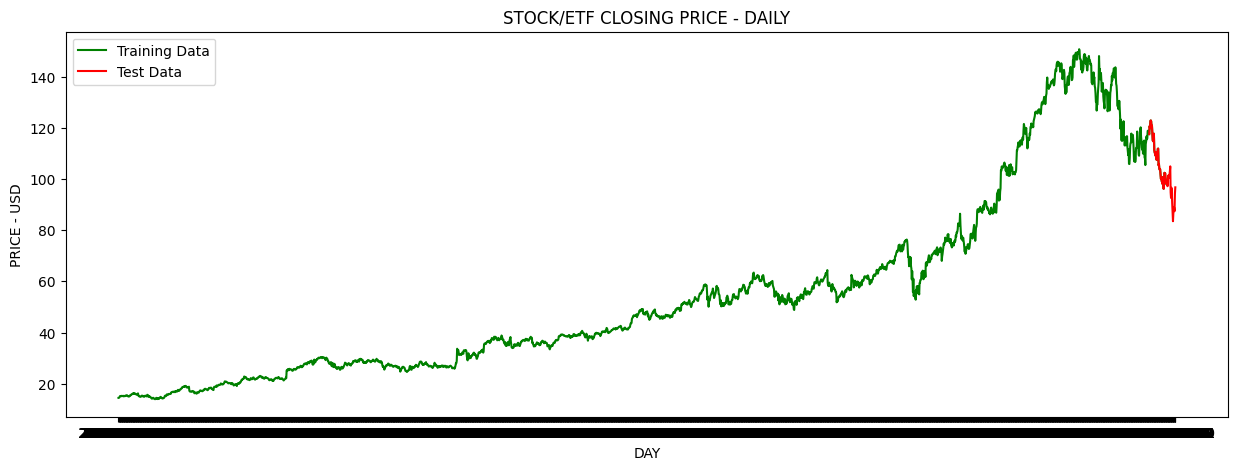

In [7]:
## Show the split of data from training, validation, and testing.

plt.plot(train_series, color='green', label = 'Training Data')
plt.plot(test_series, color='red', label = 'Test Data')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 6. Build the LightGBM Model

In [8]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

## 7. Forecast and Compare with Test Data

In [9]:
## Check the forecasting accuracy of LightGBM

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 5.0415
  LightGBM MAPE : 5.1405
  LightGBM RMSE : 5.9577


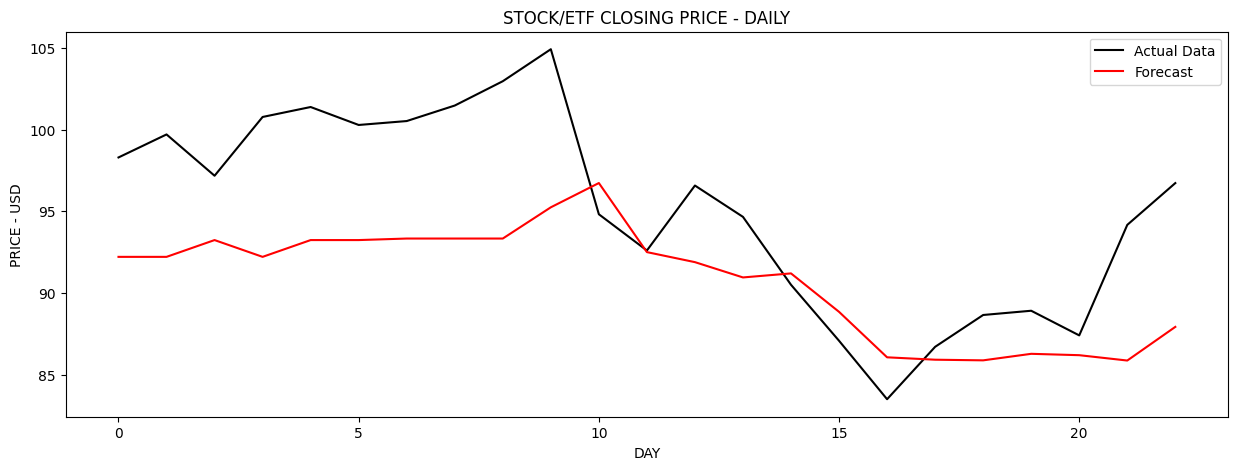

In [10]:
## Graphically compare the forecast vs actual data.

plt.plot(test_y, color='black', label = 'Actual Data')
plt.plot(forecast, color='red', label = 'Forecast')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 8. Compare Forecast Accuracy with Benchmarks

Compare the forecasting accuracy of the LightGBM with Naive and Seasonal Naive.
<br>
The LightGBM forecast output was based on the text_x dataset input.
<br>
The LightGBM forecast output was compared with the text_y actual data.
<br>
The errors were computed as MAE and MAPE.  These were compared with the benchmarks,

In [11]:
## Copied from previous notebook and modified as needed

s1_naive = series[-24:-1].to_numpy()
s7_naive = series[-30:-7].to_numpy()
s30_naive = series[-51:-28].to_numpy()
s365_naive = series[-359:-336].to_numpy()
s20_naive = series[-43:-10].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print(' s20-Naive MAE: %.4f' % (np.mean(np.abs(s20_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))
print('')
print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print(' s20-Naive MAPE: %.4f' % (np.mean(np.abs(s20_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))

     Naive MAE: 6.7519
  s7-Naive MAE: 6.3266
 s30-Naive MAE: 9.3706
s365-Naive MAE: 32.6575
 s20-Naive MAE: 6.4830
  LightGBM MAE: 5.0415

     Naive MAPE: 7.1743
  s7-Naive MAPE: 6.8814
 s30-Naive MAPE: 10.2186
s365-Naive MAPE: 34.8330
 s20-Naive MAPE: 7.1182
  LightGBM MAPE: 5.1405


## 9. Tune the LightGBM Hyperparameters

Determine the best window setting for the LightGBM model.

  5 --- MAE: -4.063 (0.181)
 10 --- MAE: -4.073 (0.146)
 15 --- MAE: -4.072 (0.151)
 20 --- MAE: -4.084 (0.149)
 23 --- MAE: -4.084 (0.182)
 30 --- MAE: -4.092 (0.139)
 45 --- MAE: -4.107 (0.177)
 90 --- MAE: -4.161 (0.194)
180 --- MAE: -4.254 (0.194)
365 --- MAE: -4.487 (0.175)


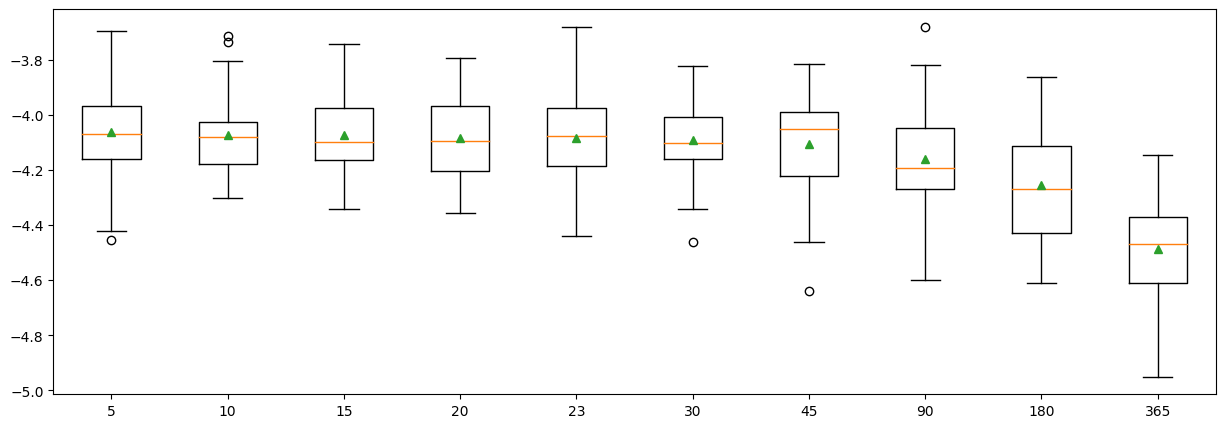

In [12]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}
windows = [5, 10, 15, 20, 23, 30, 45, 90, 180, 365]
results = []
names = []
for w in windows:
    window_size = w
    train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
    train_y = train_y.flatten()
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    print('%3d --- MAE: %.3f (%.3f)' % (w, np.mean(scores), np.std(scores)))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

## 10. Adjust the Hyperparameters

Use the window size that produced the lowest Mean Absolute Error. Compare the resulting MAE.

In [13]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
#test_size = int(len(series)*0.2)
test_size = 23
split_time = len(series) - test_size
train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2663, 30)
(2663,)
(23, 30)
(23,)


## 11. Re-Build the LightGBM 

In [14]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

## 12. Re-Forecast and Compare

In [15]:
## Re-Run the prediction model and check the resulting forecasting accuracy

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 5.4055
  LightGBM MAPE : 5.5235
  LightGBM RMSE : 6.3486


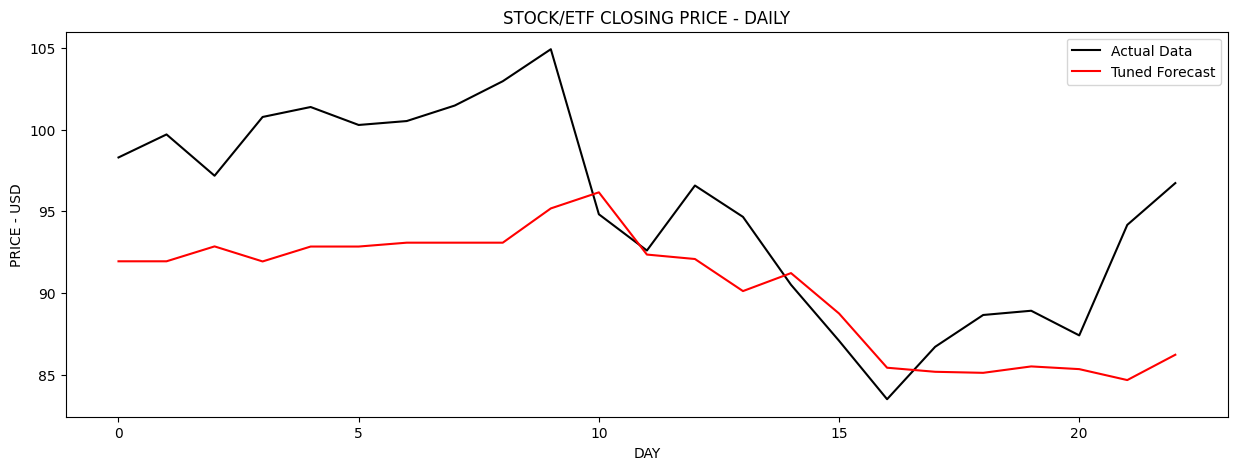

In [16]:
## Graphically compare the forecast vs actual data.

plt.plot(test_y, color='black', label = 'Actual Data')
plt.plot(forecast, color='red', label = 'Tuned Forecast')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

In [17]:
print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print(' s20-Naive MAE: %.4f' % (np.mean(np.abs(s20_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))
print('')
print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print(' s20-Naive MAPE: %.4f' % (np.mean(np.abs(s20_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))

     Naive MAE: 6.7519
  s7-Naive MAE: 6.3266
 s30-Naive MAE: 9.3706
s365-Naive MAE: 32.6575
 s20-Naive MAE: 6.4830
  LightGBM MAE: 5.4055

     Naive MAPE: 7.1743
  s7-Naive MAPE: 6.8814
 s30-Naive MAPE: 10.2186
s365-Naive MAPE: 34.8330
 s20-Naive MAPE: 7.1182
  LightGBM MAPE: 5.5235


## 13. Recursive Forecast compared with Test Dataset

Recursive Forecasting using the first element of the Test Data Set.  Then compare with the Test Dataset.

In [18]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
#test_size = int(len(series)*0.2)
test_size = 23
split_time = len(series) - test_size
train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2663, 30)
(2663,)
(23, 30)
(23,)


            One-Step MAE : 5.4055
Recursive Multi-Step MAE : 23.0564

            One-Step MAPE: 5.5235
Recursive Multi-Step MAPE: 24.6396


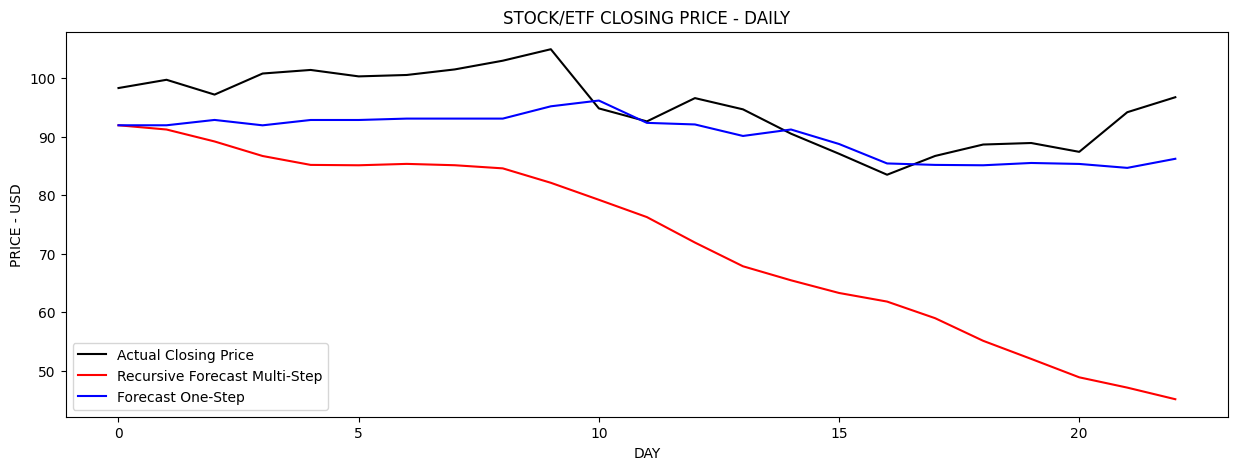

In [19]:
recursive_x = test_x[0, :]

forecast_ms = []
for i in range(test_x.shape[0]):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)
    
forecast_ms_rec = np.asarray(forecast_ms).flatten()
forecast_os = model.predict(test_x)

print('            One-Step MAE : %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Recursive Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y))))
print('')
print('            One-Step MAPE: %.4f' % (np.mean(np.abs(forecast_os - test_y)/test_y*100)))
print('Recursive Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y)/test_y*100)))

plt.plot(test_y, color='black', label = 'Actual Closing Price')
plt.plot(forecast_ms_rec, color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_os, color='blue', label = 'Forecast One-Step')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 14. Direct Forecast compared with Test Dataset

Direct Forecast using the first element of the Test Dataset and then compare with the Test Dataset.

In [20]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 23

### TRAIN VAL SPLIT ### (include shuffling later)
#test_size = int(len(series)*0.2)
test_size = 23
split_time = len(series) - test_size
train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

#train_y = train_y.flatten()
#test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2641, 30)
(2641, 23)
(1, 30)
(1, 23)


In [21]:
## Copied from previous notebook and modified as needed

model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)

model.fit(train_x, train_y)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

         One-Step MAE : 5.4055
Direct Multi-Step MAE : 15.9289

         One-Step MAPE: 5.5235
Direct Multi-Step MAPE: 17.3528


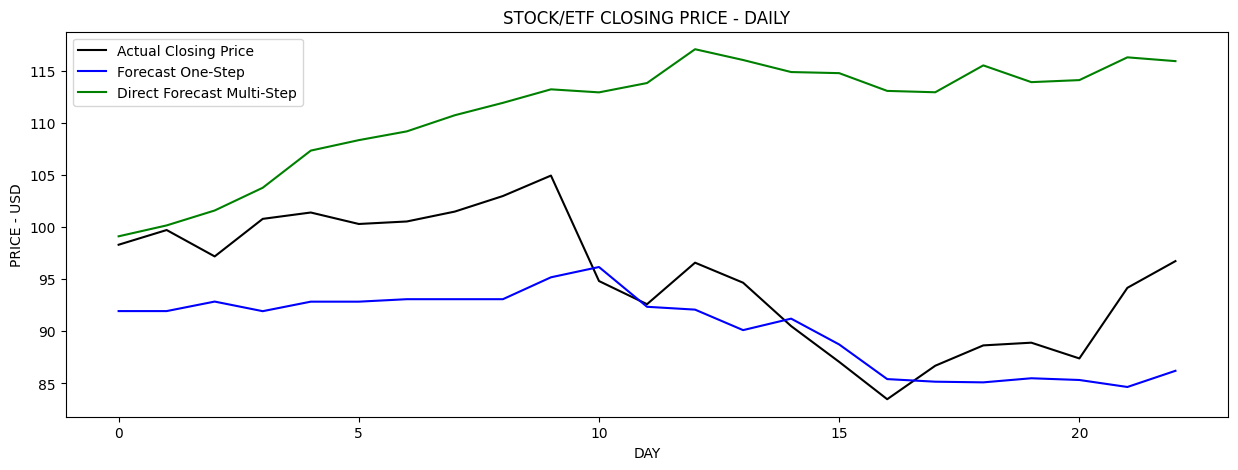

In [22]:
## Copied from previous notebook and modified as needed

forecast_ms_dir = model.predict(test_x)


print('         One-Step MAE : %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Direct Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y))))
print('')
print('         One-Step MAPE: %.4f' % (np.mean(np.abs(forecast_os - test_y)/test_y*100)))
print('Direct Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y)/test_y*100)))


plt.plot(test_y[-1], color='black', label = 'Actual Closing Price')
#plt.plot(forecast_ms_rec, color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_os, color='blue', label = 'Forecast One-Step')
plt.plot(forecast_ms_dir.flatten(), color='green', label = 'Direct Forecast Multi-Step')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()


## 15. Combined Recursive and Direct Forecasting

Combining Recursive and Direct Forecast with equal weights.

            One-Step MAE : 5.4055
   Direct Multi-Step MAE : 15.9289
Recursive Multi-Step MAE : 23.0564
 Combined Multi-Step MAE : 4.3954

            One-Step MAPE: 5.5235
   Direct Multi-Step MAPE: 17.3528
Recursive Multi-Step MAPE: 24.6396
 Combined Multi-Step MAPE: 4.5908


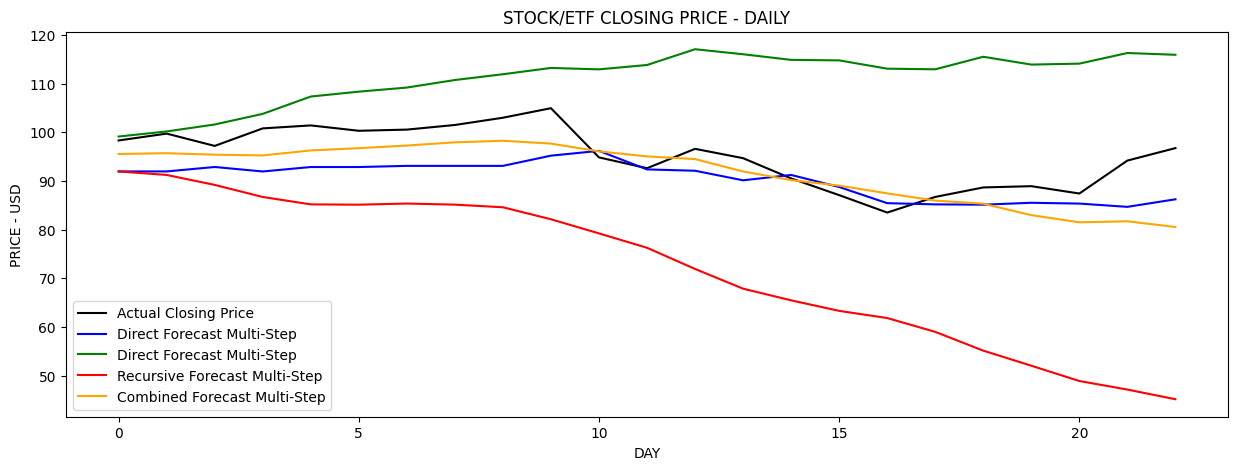

In [23]:
## Copied from previous notebook and modified as needed

forecast_ms_comb = 0.5*forecast_ms_dir.flatten() + 0.5*forecast_ms_rec


print('            One-Step MAE : %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('   Direct Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y))))
print('Recursive Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y))))
print(' Combined Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_comb - test_y))))
print('')
print('            One-Step MAPE: %.4f' % (np.mean(np.abs(forecast_os - test_y)/test_y*100)))
print('   Direct Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y)/test_y*100)))
print('Recursive Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y)/test_y*100)))
print(' Combined Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_comb - test_y)/test_y*100)))

plt.plot(test_y[-1], color='black', label = 'Actual Closing Price')
plt.plot(forecast_os, color='blue', label = 'Direct Forecast Multi-Step')
plt.plot(forecast_ms_dir.flatten(), color='green', label = 'Direct Forecast Multi-Step')
plt.plot(forecast_ms_rec, color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_ms_comb, color='orange', label = 'Combined Forecast Multi-Step')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 16. Recursive Forecasting Beyond the Dataset

Recursive forecast starting with the last element of the Test Dataset.
Forecast one day ahead.
Then, add the new forcast to the latest element in the input dataset. 
Then, remove the oldest element from the input dataset.
Then, repeate the above process.

In [24]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
#test_size = int(len(series)*0.2)
test_size = 23
split_time = len(series) - test_size
train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2663, 30)
(2663,)
(23, 30)
(23,)


In [25]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

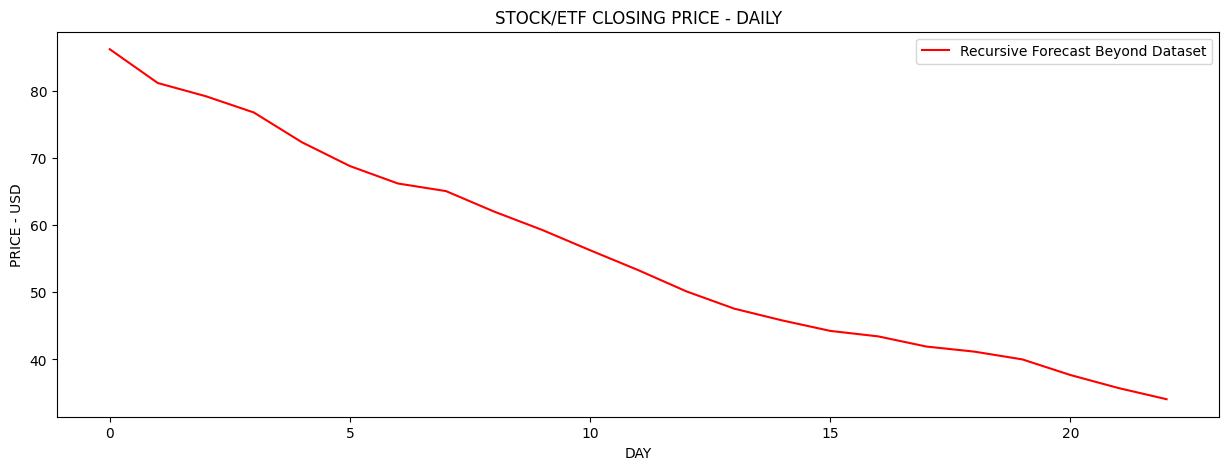

In [26]:
recursive = 23

recursive_x = test_x[-1, :]
forecast_ms = []
for i in range(recursive):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)
    
forecast_ms_rec_beyond = np.asarray(forecast_ms).flatten()

plt.plot(forecast_ms_rec_beyond, color='red', label = 'Recursive Forecast Beyond Dataset')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 17. Direct Forecasting Beyond the Dataset

Direct forecast using the last element of the Test Dataset.
Forecast multi-period ahead using the same last element of the Test Dataset.

In [27]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 23

### TRAIN VAL SPLIT ### (include shuffling later)
#test_size = int(len(series)*0.2)
test_size = 23
split_time = len(series) - test_size
train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

#train_y = train_y.flatten()
#test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2641, 30)
(2641, 23)
(1, 30)
(1, 23)


In [28]:
## Copied from previous notebook and modified as needed

model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)

model.fit(train_x, train_y)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

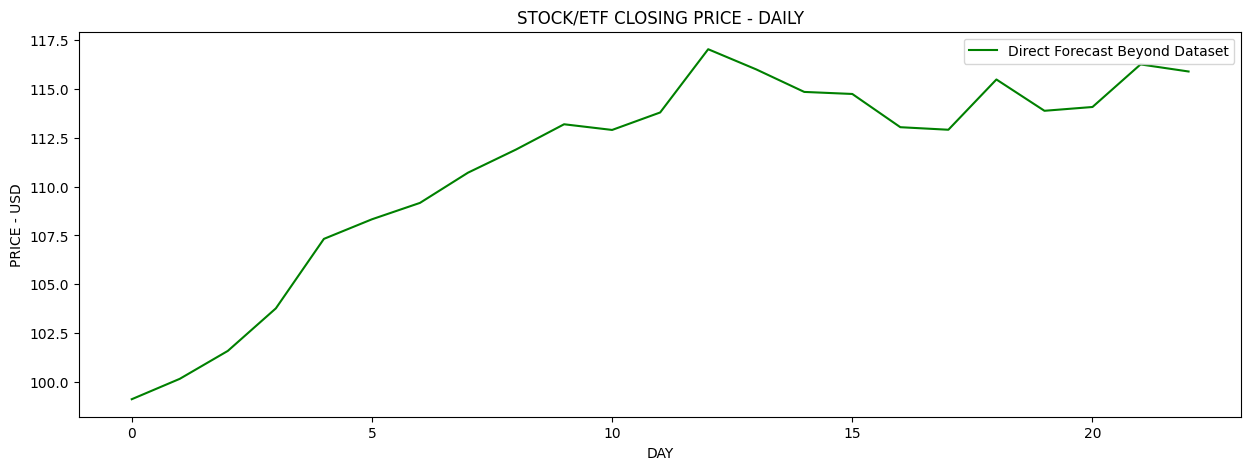

In [29]:
## Copied from previous notebook and modified as needed

forecast_ms_dir_beyond = model.predict(test_x[-1:])

plt.plot(forecast_ms_dir_beyond.flatten(), color='green', label = 'Direct Forecast Beyond Dataset')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 18. Combined Recursive and Direct Forecast Beyond Dataset

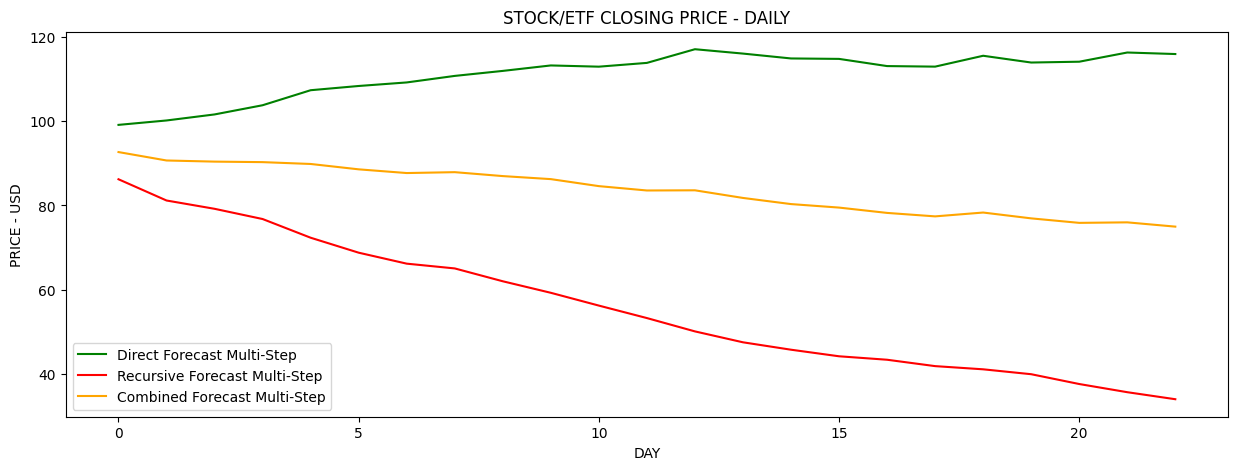

In [30]:
## Copied from previous notebook and modified as needed

forecast_ms_comb_beyond = 0.5*forecast_ms_dir_beyond.flatten() + 0.5*forecast_ms_rec_beyond

plt.plot(forecast_ms_dir_beyond.flatten(), color='green', label = 'Direct Forecast Multi-Step')
plt.plot(forecast_ms_rec_beyond, color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_ms_comb_beyond, color='orange', label = 'Combined Forecast Multi-Step')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 19. Compare with the latest Actual Data

[*********************100%***********************]  1 of 1 completed
Recursive LightGBM MAE  : 24.6396
Recursive LightGBM MAPE : 25.2002
Recursive LightGBM RMSE : 25.8566

   Direct LightGBM MAE  : 1.3719
   Direct LightGBM MAPE : 1.4168
   Direct LightGBM RMSE : 1.7629

 Combined LightGBM MAE  : 8.2961
 Combined LightGBM MAPE : 8.4748
 Combined LightGBM RMSE : 8.5584


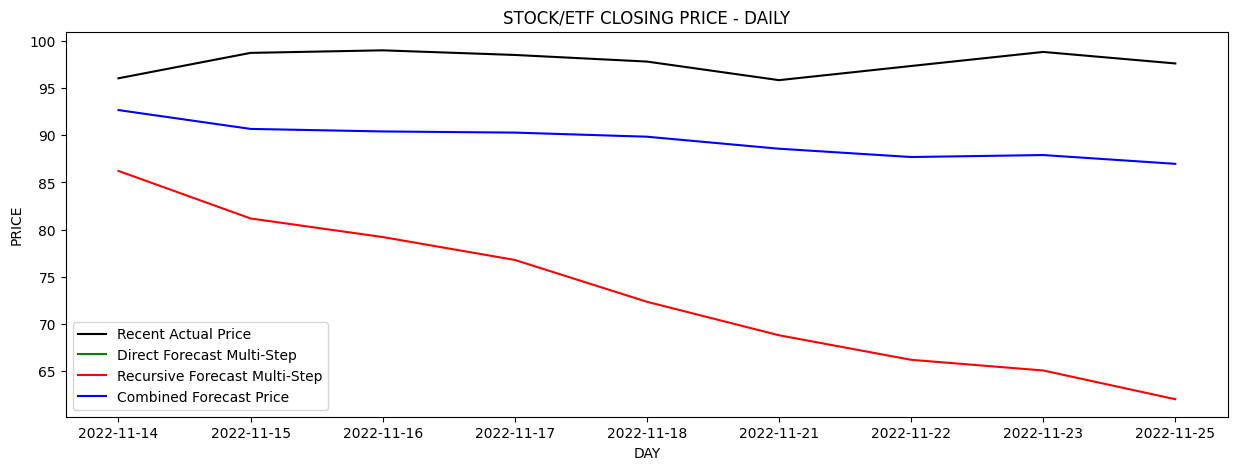

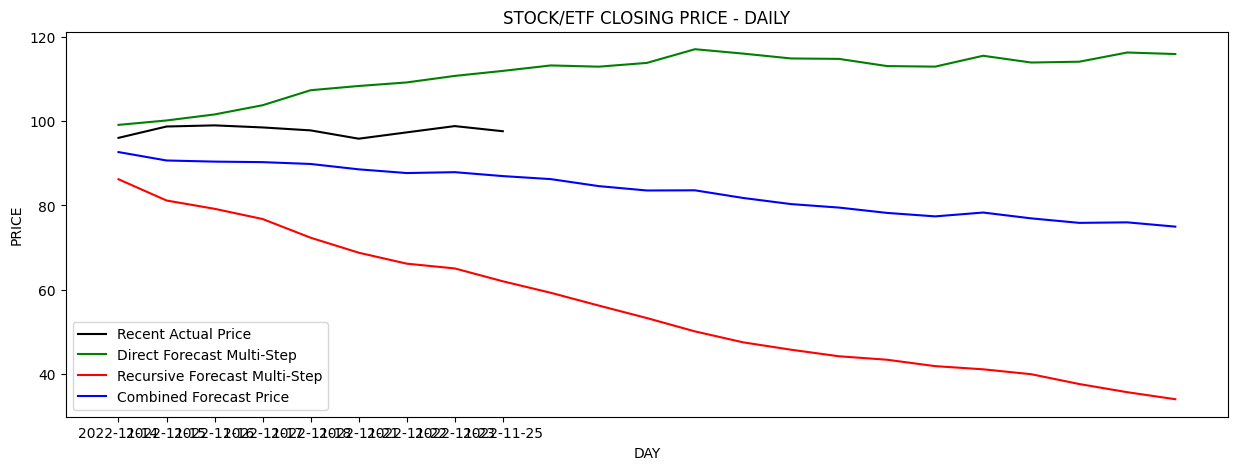

In [31]:
ticker = 'GOOG'
filename_new = ticker+'_new.csv'
startdate = '2022-11-13'
ticker_data = yf.download(ticker, start=startdate)
ticker_data.to_csv(filename_new)

df = pd.read_csv(filename_new,
    index_col='Date')
df = df.dropna()
series_latest = pd.DataFrame(df['Close'])

latest_len = len(series_latest)
forecast_ms_comb_latest = forecast_ms_comb_beyond[0:latest_len]
forecast_ms_dir_latest = forecast_ms_dir_beyond[0:latest_len, 0]
forecast_ms_rec_latest = forecast_ms_rec_beyond[0:latest_len]

print('Recursive LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast_ms_rec_latest - series_latest['Close'].values))))
print('Recursive LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast_ms_rec_latest - series_latest['Close'].values)/series_latest['Close'].values*100)))
print('Recursive LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast_ms_rec_latest - series_latest['Close'].values)**2))))
print('')
print('   Direct LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast_ms_dir_latest - series_latest['Close'].values))))
print('   Direct LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast_ms_dir_latest - series_latest['Close'].values)/series_latest['Close'].values*100)))
print('   Direct LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast_ms_dir_latest - series_latest['Close'].values)**2))))
print('')
print(' Combined LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast_ms_comb_latest - series_latest['Close'].values))))
print(' Combined LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast_ms_comb_latest - series_latest['Close'].values)/series_latest['Close'].values*100)))
print(' Combined LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast_ms_comb_latest - series_latest['Close'].values)**2))))

plt.plot(series_latest, color='black', label = 'Recent Actual Price')
plt.plot(forecast_ms_dir_latest.flatten()[:latest_len], color='green', label = 'Direct Forecast Multi-Step')
plt.plot(forecast_ms_rec_latest, color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_ms_comb_latest, color='blue', label = 'Combined Forecast Price')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE")
plt.legend()
plt.show()

plt.plot(series_latest, color='black', label = 'Recent Actual Price')
plt.plot(forecast_ms_dir_beyond.flatten(), color='green', label = 'Direct Forecast Multi-Step')
plt.plot(forecast_ms_rec_beyond, color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_ms_comb_beyond, color='blue', label = 'Combined Forecast Price')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE")
plt.legend()
plt.show()

## 20. Feature Importance

Generate the feature importance metrics.

In [32]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 23
split_time = len(series) - test_size
train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

feature_name_list = ['lag_' + str(i+1) for i in range(window_size)]

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          feature_name = feature_name_list,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

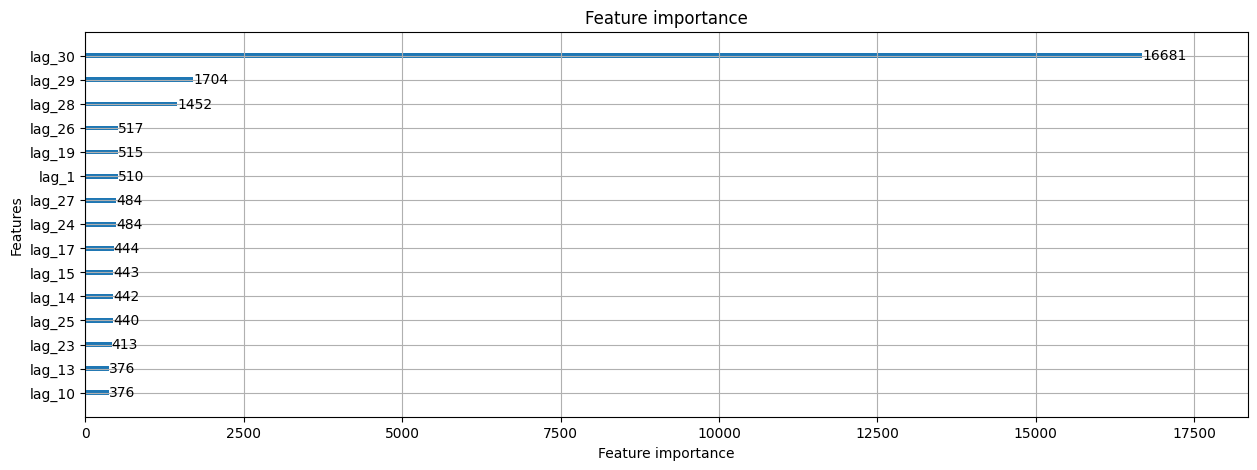

In [33]:
## Copied from previous notebook and modified as needed

lgb.plot_importance(model, max_num_features = 15, importance_type = 'split')
plt.show()

## 21. Summary

In summary, this supplementary notebook demonstrated how to use the LightGBM, that was used by the winning team in the M5 Forecasting Competiton, for forecasting the Google (GOOG) stock price as part of the inputs to the participant's entry to the 10th Month of the M6 Competition.

The forecasting accuracy of the LighgGBM model used for forecasting the Google (GOOG) stock price was compared with Naive and Seasonal Naive forecast outputs.  Based on the comparison, the LightGMB forecasting accuracy for the Google stock price was significantly better. The forecasting accuracy of the LightGBM for the 10th Month Google stock price dataset is at around 5.5% Mean Absolute Percentage Error (MAPE) compared with the MAPE Naive and sNaive benchmarks for the same dataset of about about 6.9% MAPE.

When compared with the latest actual stock prices of Google (GOOG), the forecasting accuracy of the tuned LightGBM showed about 1.4% MAPE or about USD1.4 for Direct and about 25.2% or about USD24.6 for Recursive.  The combined forecast if about 8.5% MAPE, which is about USD8.30 in Price.


## 22. References

[1] S. Makridakis, E. Spiliotis, and V. Assimakopoulos. The M5 Accuracy competition: Results, findings and conlusions. 2020.

[2] S. Makridakis, E. Spiliotis, V. Assimakopoulos, Z. Chen, A. Gaba, I. Tsetlin, and R. Winkler. The M5 Uncertainty competition: Results, findings and conlusions. 2020.

[3] V. Jose, and R. Winkler. Evaluating quantile assessments. Operations research, 2009.

[4] A. Gaba, I. Tsetlin, and R. Winkler. Combining interval forecasts. Decision Analysis, 2017.